<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления 

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [1]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

--2021-02-27 14:49:06--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin?download=1’

SO_vectors_200.bin? 100%[===================>]   1.35G  74.7MB/s    in 16s     

2021-02-27 14:49:23 (84.7 MB/s) - ‘SO_vectors_200.bin?download=1’ saved [1453905423/1453905423]



In [2]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin?download=1", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [3]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [4]:
print(f"Num of words: {len(wv_embeddings.index2word)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место? 

In [5]:
wv_embeddings.most_similar('dog')[:5]

[('animal', 0.8564180135726929),
 ('dogs', 0.7880867123603821),
 ('mammal', 0.7623804807662964),
 ('cats', 0.7621253728866577),
 ('animals', 0.760793924331665)]

In [8]:
[i for i,(w,_) in enumerate(wv_embeddings.most_similar('dog')[:5],1) if "cat" in w]

[4]

да входит, на 4 месте

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [10]:
import numpy as np
import re
# you can use your tokenizer
# for example, from nltk.tokenize import WordPunctTokenizer
class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall('\w+', text)

tokenizer = MyTokenizer()

In [24]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    ret = [embeddings[t] for t in tokenizer.tokenize(question.strip()) if t in embeddings]
    if len(ret)==0:
      return np.zeros((dim,), dtype="float")
    else:
      return np.array(ret).mean(0)


Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [29]:
ret = question_to_vec("I love neural networks", wv_embeddings, tokenizer)[2]
f"{ret:.2f}"

'-1.29'

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv 
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. 
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$


In [171]:
round(1/(np.log(10)/np.log(2))*(int(9<=10)),1)

0.3

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [30]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    return len([rank for rank in dup_ranks if rank <= k]) / len(dup_ranks)    

In [33]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """
    '''your code'''
    return sum([1 / np.log2(1 + rank) for rank in dup_ranks if rank <= k]) / len(dup_ranks)

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [36]:
import pandas as pd

In [40]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наги кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [candidates_ranking[i].index(copy_answers[i]) + 1 for i in range(len(copy_answers))]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [41]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [44]:
!gdown https://drive.google.com/uc?id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_

Downloading...
From: https://drive.google.com/uc?id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_
To: /content/stackoverflow_similar_questions.zip
131MB [00:00, 183MB/s]


In [45]:
!unzip stackoverflow_similar_questions.zip

Archive:  stackoverflow_similar_questions.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/train.tsv          
  inflating: data/validation.tsv     


Считайте данные.

In [46]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

Нам понадобиться только файл validation.

In [47]:
validation_data = read_corpus('./data/validation.tsv')

Кол-во строк

In [48]:
len(validation_data)

3760

Размер нескольких первых строк

In [49]:
for i in range(5):
    print(i + 1, len(validation_data[0]))

1 1001
2 1001
3 1001
4 1001
5 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [102]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    candidate_vecs = np.stack([question_to_vec(candidate, embeddings, tokenizer=tokenizer, dim=dim) for candidate in candidates])
    sim_scores = cosine_similarity(candidate_vecs, question_to_vec(question, embeddings, tokenizer=tokenizer, dim=dim).reshape(1, -1))
    candidate_list = sorted([(i, score[0]) for i, score in enumerate(sim_scores)], key=lambda x: x[1], reverse=True)
    return np.array([(i, candidates[i]) for i, score in candidate_list])

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [57]:
questions = ['converting string to list', 'Sending array via Ajax fails'] 

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],
              
              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [79]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(1, 'WPF- How to update the changes in list item of a list'), (0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [60]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(0, 'Getting all list items of an unordered list in PHP'), #скрыт -> добавил
            (2, 'select2 not displaying search results'), #скрыт
            (1, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

In [61]:
print("021")

021


Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [62]:
from tqdm.notebook import tqdm

In [103]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

In [104]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.285 | Hits@   1: 0.285
DCG@   5: 0.342 | Hits@   5: 0.393
DCG@  10: 0.360 | Hits@  10: 0.449
DCG@ 100: 0.406 | Hits@ 100: 0.679
DCG@ 500: 0.431 | Hits@ 500: 0.879
DCG@1000: 0.444 | Hits@1000: 1.000



как-то не очень, довольно низкие хиты, @1, @5 - с другой стороны мы не обрабатывали текст, который наверняка содержит стоп слова и оппечатки и к тому же вероятно отличен от текста на котором тренировалась дефолтная модель - компьютерная лексика и т.д.

### Эмбеддинги, обученные на корпусе похожих вопросов

In [106]:
train_data = read_corpus('./data/train.tsv')

In [110]:
train_data[42]

['How to remove specific value from array using jQuery',
 'Remove set of items from an array jQuery',
 'javascript remove array from array']

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

> согласно https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf
больше окно, больше информации о теме / предметной области, специфичных слов. меньшие окна имеют тенденцию улавливать больше о самом слове: какие еще слова похожи? по умолчанию окно = 5

In [112]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


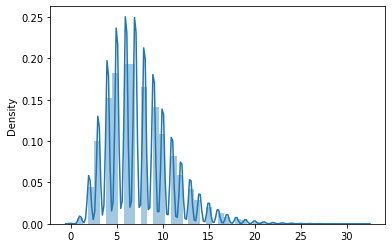

In [120]:
sns.distplot(np.array([s.count(" ") for l in train_data for s in l]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


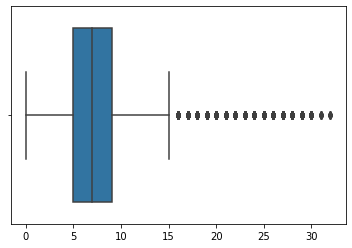

In [121]:
sns.boxplot(np.array([s.count(" ") for l in train_data for s in l]))

давайте возьмем среднее длин предложений, - 7

In [131]:
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [133]:
stopwords = set(stopwords.words('english'))

In [139]:
def clean_sentence(s, lower=True):
  s = " ".join(t.strip(punctuation+" ") for t in s.split())
  for c in punctuation:
    s = s.replace(c, " ") 
  if lower:
    s=s.lower()
  return s


# words = [[w for w in tokenizer.tokenize(clean_sentence(s)) if w not in stopwords] for l in train_data for s in l]
words = [tokenizer.tokenize(clean_sentence(s)) for l in train_data for s in l]

In [140]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=3,             # consider words that occured at least 5 times
                 window=7,
                 workers=4).wv

In [141]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

In [138]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.263 | Hits@   1: 0.263
DCG@   5: 0.330 | Hits@   5: 0.390
DCG@  10: 0.351 | Hits@  10: 0.455
DCG@ 100: 0.395 | Hits@ 100: 0.675
DCG@ 500: 0.421 | Hits@ 500: 0.875
DCG@1000: 0.434 | Hits@1000: 1.000



In [142]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.201 | Hits@   1: 0.201
DCG@   5: 0.249 | Hits@   5: 0.292
DCG@  10: 0.267 | Hits@  10: 0.346
DCG@ 100: 0.314 | Hits@ 100: 0.586
DCG@ 500: 0.344 | Hits@ 500: 0.829
DCG@1000: 0.362 | Hits@1000: 1.000



In [143]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=1,             # consider words that occured at least 5 times
                 window=7,
                 workers=4).wv
      

In [144]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

In [145]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.202 | Hits@   1: 0.202
DCG@   5: 0.249 | Hits@   5: 0.291
DCG@  10: 0.263 | Hits@  10: 0.337
DCG@ 100: 0.310 | Hits@ 100: 0.572
DCG@ 500: 0.341 | Hits@ 500: 0.819
DCG@1000: 0.360 | Hits@1000: 1.000



In [146]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=1,             # consider words that occured at least 5 times
                 window=5,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.196 | Hits@   1: 0.196
DCG@   5: 0.242 | Hits@   5: 0.282
DCG@  10: 0.260 | Hits@  10: 0.337
DCG@ 100: 0.304 | Hits@ 100: 0.562
DCG@ 500: 0.337 | Hits@ 500: 0.814
DCG@1000: 0.356 | Hits@1000: 1.000



In [147]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=2,             # consider words that occured at least 5 times
                 window=5,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.192 | Hits@   1: 0.192
DCG@   5: 0.242 | Hits@   5: 0.287
DCG@  10: 0.258 | Hits@  10: 0.335
DCG@ 100: 0.304 | Hits@ 100: 0.573
DCG@ 500: 0.336 | Hits@ 500: 0.818
DCG@1000: 0.355 | Hits@1000: 1.000



In [148]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=3,             # consider words that occured at least 5 times
                 window=3,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.188 | Hits@   1: 0.188
DCG@   5: 0.232 | Hits@   5: 0.273
DCG@  10: 0.250 | Hits@  10: 0.327
DCG@ 100: 0.293 | Hits@ 100: 0.543
DCG@ 500: 0.327 | Hits@ 500: 0.815
DCG@1000: 0.347 | Hits@1000: 1.000



In [149]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=7,             # consider words that occured at least 5 times
                 window=7,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.195 | Hits@   1: 0.195
DCG@   5: 0.244 | Hits@   5: 0.288
DCG@  10: 0.261 | Hits@  10: 0.338
DCG@ 100: 0.309 | Hits@ 100: 0.583
DCG@ 500: 0.340 | Hits@ 500: 0.827
DCG@1000: 0.358 | Hits@1000: 1.000



In [150]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=7,             # consider words that occured at least 5 times
                 window=8,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.201 | Hits@   1: 0.201
DCG@   5: 0.247 | Hits@   5: 0.290
DCG@  10: 0.264 | Hits@  10: 0.343
DCG@ 100: 0.311 | Hits@ 100: 0.584
DCG@ 500: 0.342 | Hits@ 500: 0.828
DCG@1000: 0.360 | Hits@1000: 1.000



In [151]:
words = [[w for w in tokenizer.tokenize(clean_sentence(s)) if w not in stopwords] for l in train_data for s in l]

from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=7,             # consider words that occured at least 5 times
                 window=8,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.267 | Hits@   1: 0.267
DCG@   5: 0.334 | Hits@   5: 0.398
DCG@  10: 0.351 | Hits@  10: 0.452
DCG@ 100: 0.396 | Hits@ 100: 0.675
DCG@ 500: 0.423 | Hits@ 500: 0.882
DCG@1000: 0.435 | Hits@1000: 1.000



In [153]:
mean_wv_embeddings = np.mean(wv_embeddings.vectors, axis=0)
std_wv_embeddings = np.std(wv_embeddings.vectors, axis=0)

In [157]:
def question_to_vec(question, embeddings, tokenizer, dim=200, normalize=True):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    ret = [(embeddings.get_vector(token) - mean_wv_embeddings) / std_wv_embeddings for token in tokenizer.tokenize(question.lower()) if token in embeddings and len(token) > 3]
    
    if len(ret)==0:
      return np.zeros((dim,), dtype="float")
    else:
      return np.array(ret).mean(0)


In [158]:
ret = question_to_vec("I love neural networks", wv_embeddings, tokenizer)[2]
f"{ret:.2f}"

'-6.35'

In [159]:
tokenizer = nltk.WordPunctTokenizer()

In [160]:
words = [[w for w in tokenizer.tokenize(clean_sentence(s)) if w not in stopwords] for l in train_data for s in l]

from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=7,             # consider words that occured at least 5 times
                 window=8,
                 workers=4).wv
      
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.356 | Hits@   1: 0.356
DCG@   5: 0.448 | Hits@   5: 0.529
DCG@  10: 0.474 | Hits@  10: 0.607
DCG@ 100: 0.521 | Hits@ 100: 0.839
DCG@ 500: 0.538 | Hits@ 500: 0.966
DCG@1000: 0.542 | Hits@1000: 1.000



### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:


1. лучше использовать токенизацию типа WordPunctTokenizer, - вообще токенизацию нужны выбирать, исходя из целей, и распределения слов в тексте и словаря, скажем если в тексте большое количество оппечаток - лучше почистить текст и по ngram (напримере того же fasttext мы это видим, как это решает проблему OOV)

2. да нормализация помогает, - помогает очистка, даже самая простая и нормализация эмбеддингов. также были проверены несколько вариантов окон - 7-8 достаточно

3. были проверены предложенные, предобученные вектора, но логично что предобученные вектора на заданном корпусе или домене, лучше. 

4. ну мы имеем специфичный корпус, и обычный word2vec, даже fasttext будет лучше, много OOV, много спец лексики. много  ambigous words - Apple в данном тексте, это скорее про телефон, чем про яблоко.

5. если использовать только word2vec , то почистить текст, взять spacy заменить соответствующие слова на \<NUMBERS>, \<HASHTAG> и т.д. а вообще лучше взять контекстуализированные эмбеддинги типа bert эмбеддингов, которые будут понимать когда apple это яблоко, а когда телефон. в идеале можно пытаться вычленить это дело в отдельные entity, - т.е. apple 5 == apple v